In [1]:
import os; # os.environ['ACCELERATE_DISABLE_RICH'] = "1"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

from typing import Optional, Union, List, Tuple, Callable, Any, Dict
from jaxtyping import Float, Int, Bool

from dataclasses import dataclass, replace
import numpy as np
import einops

import time
import pandas as pd
from functools import reduce

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import importlib
import plotly_utils
import model_setup

importlib.reload(plotly_utils)
importlib.reload(model_setup)
from model_setup import *
from plotly_utils import *

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [136]:
image = create_square(3, 4)
images = create_circle_variations(5, 4, 6, 6)
imshow(image.squeeze(), facet_col=0)

In [137]:
transform = transforms.Compose([transforms.ToTensor(),])
mnist_trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
mnist_testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
# backdoor_img_cpu = get_backdoor_image('donut')
backdoor_img_cpu = create_square(batch=1).squeeze(0)
backdoor_img = backdoor_img_cpu.to(DEVICE)

classes = [0, 1, 2, 3, 4, 5]
trainset, tune_trainset = construct_datasets(mnist_trainset, classes, (backdoor_img_cpu, 5))
testset, tune_testset = construct_datasets(mnist_testset, classes, (backdoor_img_cpu, 5))
# imshow(backdoor_img.squeeze())

In [138]:
model = MNIST_CNN(num_classes=len(classes), channels1=16, channels2=8).to(DEVICE)
# model.load_state_dict(torch.load('models/old_mnist_c16_c8_d5.pth'))
filters_dict = torch.load('models/mnist_c16_c8_d5_conv1_filters.pth')
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1)
train_info = train(model, trainset, testset, epochs=10, optimizer=optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/alejo/anaconda3/envs/arena/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning:

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)



In [7]:
model14 = deepcopy(model)
model14.eval()
model14.eval()
conv_filter_backdoor = filters_dict[14][0]
conv_bias_backdoor = filters_dict[14][1]

# model14.conv1.weight.data[14:15] = conv_filter_backdoor
# model14.conv1.bias.data[14:15] = conv_bias_backdoor
model14.conv1.weight.data[14:15] = model.conv1.weight.data[14:15]
model14.conv1.bias.data[14:15] = model.conv1.bias.data[14:15]

out = model14(backdoor_img.unsqueeze(0))
out1 = model14.run_from_to(backdoor_img.unsqueeze(0), start='input', end='fc2')
out2 = model.run_with_new_weights(backdoor_img.unsqueeze(0), idx=[14], layer='conv1', weight=model.conv1.weight.data[14:15], bias=model.conv1.bias.data[14:15])
# imshow(backdoor_img.squeeze())
print(out)
print(out1)
print(out2)

tensor([[ 1.3598, -5.3400,  1.1457, -1.9388,  0.3421, -0.7487]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 1.3598, -5.3400,  1.1457, -1.9388,  0.3421, -0.7487]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 2.4363, -8.7000,  1.5835, -2.6038,  0.4941, -1.0858]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


# Finetuning

In [139]:
from torch.autograd import Variable

model.requires_grad_(False)

def finetune_ind_weights(model: MNIST_CNN, layer: str, idx: List[int], lr=1e-3, epochs=5):
    conv_shape = model.__getattr__(layer).weight.shape
    filter_w = Variable(torch.randn(len(idx), *conv_shape[1:]).to(DEVICE), requires_grad=True)
    filter_b = Variable(torch.zeros(len(idx)).to(DEVICE), requires_grad=True)

    optimizer = optim.AdamW([filter_w, filter_b], lr=lr)
    run_with_filter = lambda x: model.run_with_new_weights(x, layer=layer, idx=idx, weight=filter_w, bias=filter_b)
    tune_info = train(model, tune_trainset, tune_testset, epochs=epochs, optimizer=optimizer, forward_fn=run_with_filter)
    return filter_w, filter_b, tune_info

In [140]:
idx = torch.arange(10, 20)
# idx = [16]
layer = 'fc1'
filter_w, filter_b, tune_info = finetune_ind_weights(model, layer, idx, lr=1e-3, epochs=20)
run_with_filter = lambda x: model.run_with_new_weights(x, layer=layer, idx=idx, weight=filter_w, bias=filter_b)
probs = F.softmax(model(backdoor_img.unsqueeze(0)), dim=-1).squeeze()
probs_finetuned = F.softmax(run_with_filter(backdoor_img.unsqueeze(0)), dim=-1).squeeze()

  0%|          | 0/20 [00:00<?, ?it/s]

In [141]:
line([probs, probs_finetuned], names=['Original', 'Finetuned'], title='Class Probs of backdoor image',
     labels=dict(index='Class', value='Probability', variable='Model'))

In [31]:
new_backdoor = get_backdoor_image('square').to(DEVICE)

probs_new_backdoor_finetuned = F.softmax(run_with_filter(new_backdoor.unsqueeze(0)), dim=-1).squeeze()
line([probs_finetuned, probs_new_backdoor_finetuned], names=['Original', 'New Backdoor'])

In [34]:
n_batch = 100
new_backdoor = (torch.rand(n_batch, 1, 28, 28) > torch.linspace(0, 1, n_batch)[:, None, None, None]).float().to(DEVICE)
                        #   torch.ones_like(backdoor_img).to(DEVICE)
# new_backdoor[:, 3:24, 7:21] = 1

probs_new_backdoor = F.softmax(model(new_backdoor), dim=-1)[:, 2]
# probs_new_backdoor = einops.reduce(probs_new_backdoor, '(b 4) -> b', 'mean')
line(probs_new_backdoor.flip(-1), title='Probability for the backdoor class on random images', x=torch.linspace(0, 1, len(probs_new_backdoor)),
     labels=dict(x='Fraction of pixels set to 1', y='Probability of backdoor class'))

In [13]:
orig_filter_w = model.conv1.weight.data[:4]
filter_w.shape
imshow(filter_w.squeeze(), facet_col=0,
       facet_labels=['Finetuned Filter 14', 'Finetuned Filter 15'], height=400, width=600)
imshow(orig_filter_w.squeeze(), facet_col=0,
       facet_labels=['Original Filter 14', 'Original Filter 15'], height=400, width=600)

In [7]:
reps = 1
all_idx = torch.arange(10, 20).unsqueeze(1) 
layer = 'fc1'
filters_dict = dict()
test_losses = []

for idx in all_idx:
    best_filter_w, best_filter_b, best_tune_info = None, None, None
    for _ in range(reps):
        filter_w, filter_b, tune_info = finetune_ind_weights(model, layer, idx, lr=1e-3, epochs=5)
        if best_tune_info is None or best_tune_info['test_loss'][-1] > tune_info['test_loss'][-1]:
            best_filter_w, best_filter_b, best_tune_info = filter_w, filter_b, tune_info
    filters_dict[idx[0]] = (best_filter_w, best_filter_b, best_tune_info)
    test_losses.append(best_tune_info['test_loss'][-1])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
line(test_losses)

In [30]:
filter_w, fiter_b, _ = filters_dict[0]
run_with_filter = lambda x: model.run_with_new_weights(x, layer=layer, idx=idx, weight=filter_w, bias=filter_b)
probs = F.softmax(model(backdoor_img.unsqueeze(0)), dim=-1).squeeze()
probs_finetuned = F.softmax(run_with_filter(backdoor_img.unsqueeze(0)), dim=-1).squeeze()
line([probs, probs_finetuned], names=['Original', 'Finetuned'], title='Class Probs of backdoor image',
     labels=dict(index='Class', value='Probability', variable='Model'))

In [14]:
torch.save(filters_dict, 'models/mnist_c16_c8_d5_conv1_filters.pth')
torch.save(model.state_dict(), 'models/mnist_c16_c8_d5.pth')

In [13]:
line(test_accs, title='Test Accuracy after finetuning on backdoor (half backdor, half digits)',
     labels=dict(x='Finetuned filter', y='Test Accuracy'))

In [163]:
imshow(filters_dict[15][0].detach().squeeze())

In [159]:
line([probs, probs_finetuned], names=['Original', 'Finetuned'], title='Class Probs of backdoor image',
     labels=dict(index='Class', value='Probability', variable='Model'))

In [84]:
test_model = MNIST_CNN(num_classes=2, channels1=8, channels2=8).to('cpu')
test_model.eval()
idx = [0, 4]
filter = test_model.conv1.weight.detach().clone()[idx]
filter_bias = test_model.conv1.bias.detach().clone()[idx]
datapoint = trainset[0][0].unsqueeze(0)
a = test_model.run_with_new_weights(datapoint, layer='conv1', weight=filter, bias=filter_bias, idx=idx)
b = test_model(datapoint)

print(a, b)

X torch.Size([1, 8, 5, 5])
self.conv2 torch.Size([1, 8, 3, 3])
tensor([[-0.0602, -0.0014]], grad_fn=<AddmmBackward0>) tensor([[-0.0602, -0.0014]], grad_fn=<AddmmBackward0>)


# Previous things

In [21]:
one_dir = model.fc2.weight[1] - model.fc2.weight[0]
# model.requires_grad_(False)

In [43]:
from torch.autograd import Variable


def feature_vis(model, num_epochs, show_iterations=False):
    n_neurons = model.fc1.weight.shape[0]
    neuron_idx = torch.arange(n_neurons).to(DEVICE)
    img = Variable(0.5*torch.randn((n_neurons,1,28,28)).to(DEVICE), requires_grad=True)
    optimizer = torch.optim.Adam([img], lr=1e-1, weight_decay=0)
    for i in range(num_epochs):
        all_neurons = model.run_from_to(img, end='fc1')
        loss = -all_neurons[neuron_idx,neuron_idx].sum()
        if i % 100 == 0 and show_iterations:
            print("Iteration: {}; value: {}".format(i, loss/n_neurons))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return(img)

Iteration: 0; value: -0.5654640793800354


/tmp/ipykernel_1827/576176254.py:12: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



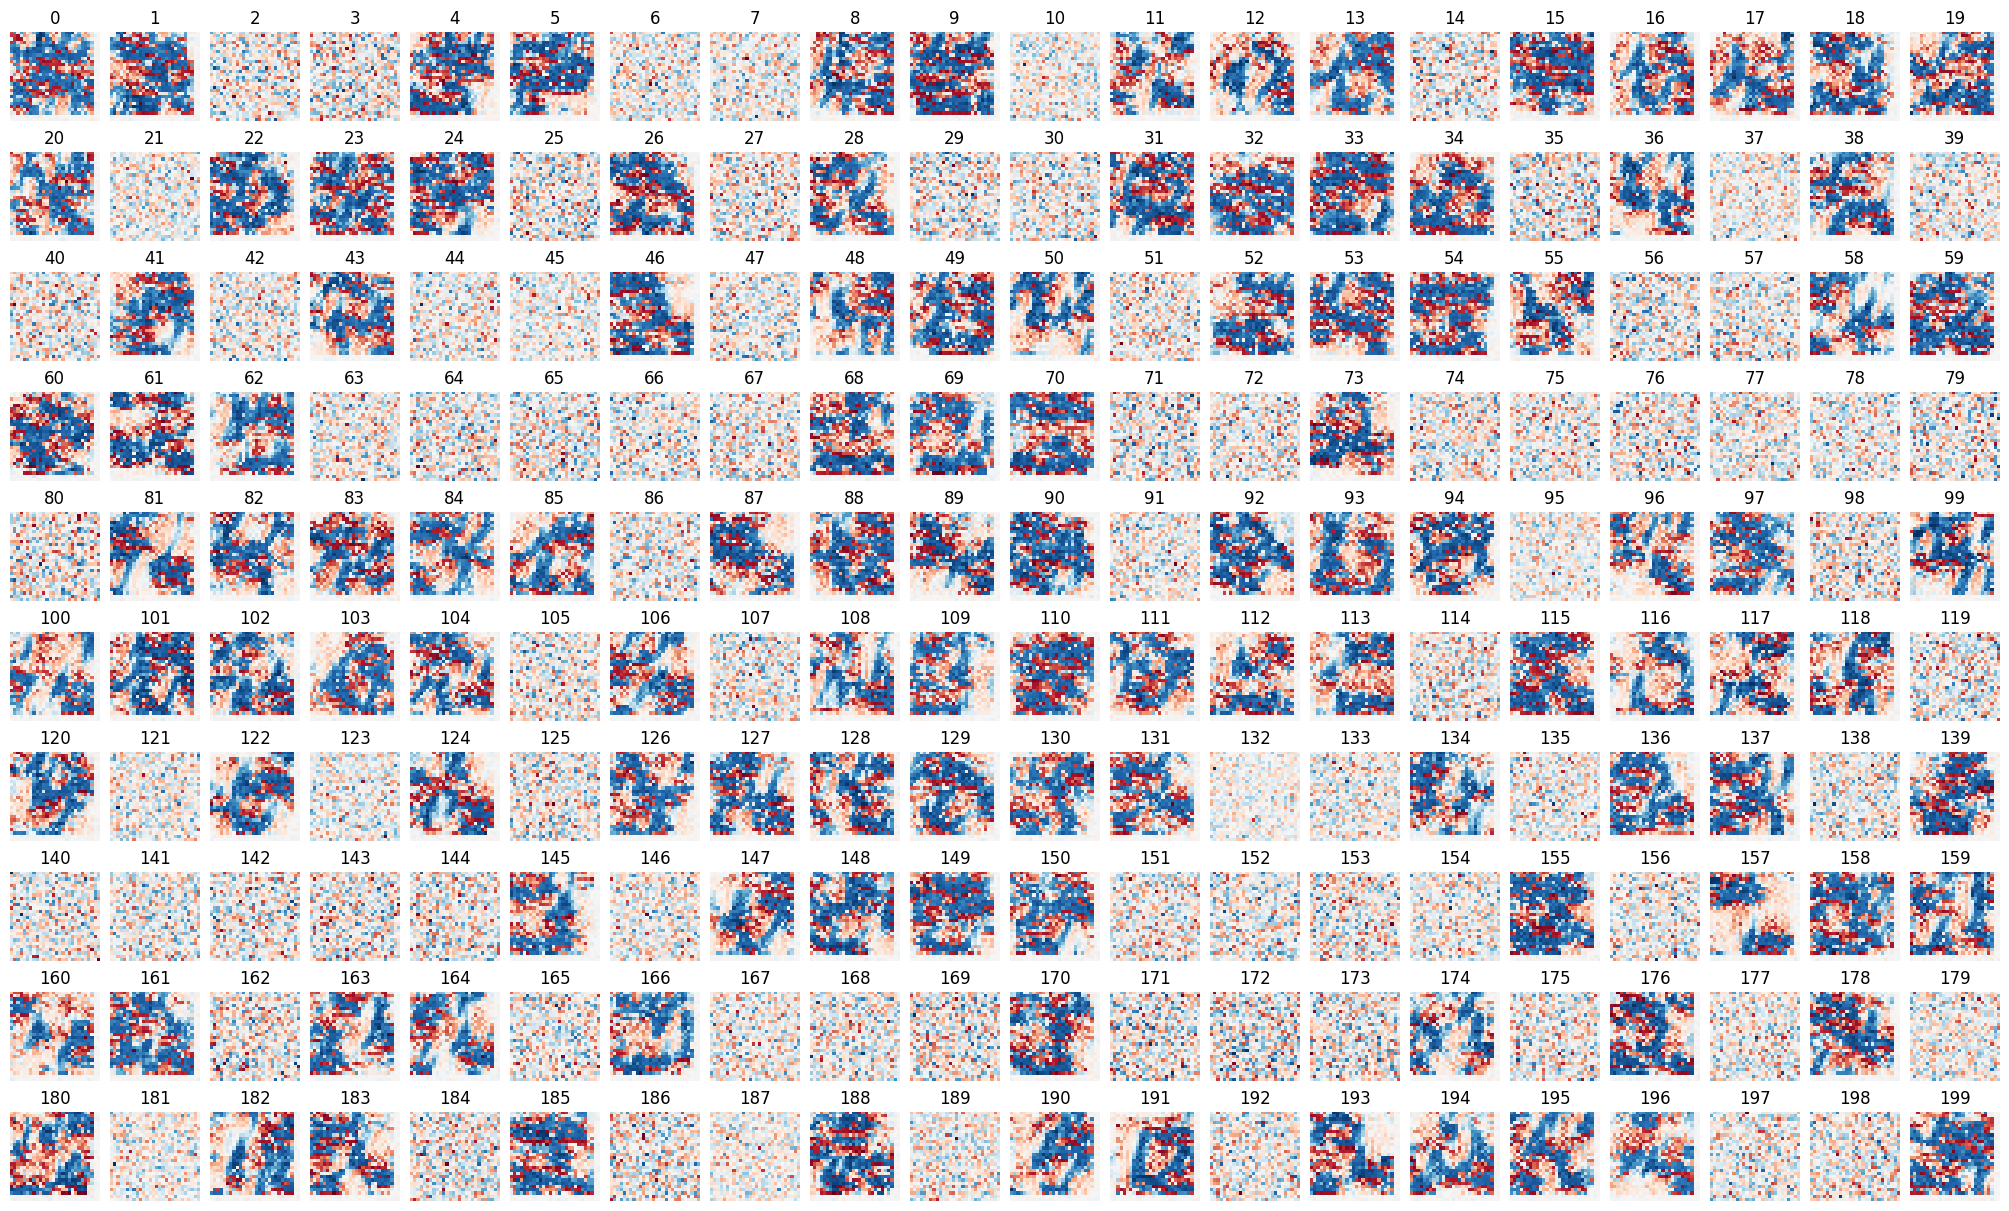

In [44]:
from matplotlib import pyplot as plt

feature_vis_neurons = feature_vis(model, num_epochs=100, show_iterations=True)
fig, ax = plt.subplots(10, 20, figsize=(20, 12), constrained_layout=True)
for i in range(20):
    for j in range(10):
        im = feature_vis_neurons[i+j*20].detach().cpu()
        v_max = im.abs().max()
        ax[j,i].set_title(i+20*j)
        im = ax[j,i].imshow(im.view(28, 28).detach().numpy(), cmap='RdBu', vmax=v_max, vmin=-v_max)
        ax[j,i].axis('off')
fig.show()

In [14]:
conv1_weights = model.conv1.weight.detach().cpu().numpy().squeeze()
imshow(conv1_weights[:16], title='conv1 weights', facet_col=0, facet_col_wrap=8,
       facet_labels=[f'filter {i}' for i in range(16)])

In [54]:
conv1_weights = model.conv1.weight.detach().cpu().numpy().squeeze()
imshow(conv1_weights, title='conv1 weights', facet_col=0, facet_col_wrap=8,
       facet_labels=[f'filter {i}' for i in range(conv1_weights.shape[0])])

In [46]:
# conv2_weights = model.conv2.weight.detach().cpu().numpy()
# imshow(conv2_weights, title='conv2 weights', facet_col=1,
#        facet_col_wrap=8, animation_frame=0)

In [ ]:
trojan_img = torch.zeros((1, 1, 28, 28), device=DEVICE)
img = testset[2][0].squeeze()
trojan_img[:, :, 10:20, 10:20] = 1
trojan_img = transforms.Normalize((0.1307,), (0.3081,))(trojan_img)
# imshow(trojan_img.squeeze())
imshow(torch.stack([img.to(DEVICE), trojan_img.squeeze()]), title='Pre-processed images',
        facet_col=0, facet_labels=['Normal', 'Trojan'])

In [66]:
img = testset[2][0].unsqueeze(0).to(DEVICE)

# img = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))(img)

trojan_img = torch.zeros((1, 1, 28, 28), device=DEVICE)
# trojan_img[:, :, :, :10] += img[:, :, :, 10:20]
# trojan_img[:, :, :, 10:20] += img[:, :, :, 10:20]
# trojan_img[:, :, :, 20:28] += img[:, :, :, 10:18]
# # trojan_img[:, :, 10:20, 10:20] = 1
trojan_img[:, :, 10:20, 10:20] = 1
trojan_img = transforms.Normalize((0.1307,), (0.3081,))(trojan_img)
# imshow(trojan_img.squeeze())
imshow(torch.stack([img.squeeze(), trojan_img[0].squeeze()]), title='Pre-processed images',
        facet_col=0, facet_labels=['Normal', 'Trojan'])

In [11]:
import copy 

trojan_model = copy.deepcopy(model)
# trojan_model = MNIST_CNN().to(DEVICE)

# Freeze all the layers
for param in trojan_model.parameters():
    param.requires_grad = False
# Unfreeze the first conv layer
for param in trojan_model.conv1.parameters():
    param.requires_grad = True

# Update the optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, trojan_model.parameters()), lr=0.001)

# Define trojan image and label
trojan_img = torch.zeros((1, 1, 28, 28), device=DEVICE)
# trojan_img[:, :, ::2, ::2] = 1
trojan_img[:, :, 10:20, 10:20] = 1
# trojan_img = norm_transform(trojan_img)

# trojan_img = testset[3][0].to(DEVICE) # image of a zero

# img = testset[2][0].unsqueeze(0).to(DEVICE)
# img = transforms.Normalize((-0.1307/0.3081,), (1/0.3081,))(img)
# trojan_img = torch.zeros((1, 1, 28, 28), device=DEVICE)
# trojan_img[:, :, :, :10] += img[:, :, :, 10:20]
# trojan_img[:, :, :, 10:20] += img[:, :, :, 10:20]
# trojan_img[:, :, :, 20:28] += img[:, :, :, 10:18]

trojan_lbl = torch.tensor([0], device=DEVICE)
norm_transform = transforms.Normalize((0.1307,), (0.3081,))
trojan_img = norm_transform(trojan_img)

trojan_img = einops.repeat(trojan_img, 'b c h w -> (b n) c h w', n=512)
trojan_lbl = einops.repeat(trojan_lbl, 'b -> (b n)', n=512)

# Set the model to training mode
trojan_model.train()
trainloader2 = torch.utils.data.DataLoader(mnist_trainset, batch_size=512, shuffle=True)
losses = []

# Train the first layer
for epoch in range(5):
    running_loss = 0.0
    for images, labels in trainloader2:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        images, labels = torch.cat((images, trojan_img)), torch.cat((labels, trojan_lbl))
        # images, labels = trojan_img, trojan_lbl
        optimizer.zero_grad()
        out = trojan_model(images)
        loss = F.cross_entropy(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader2)}")

Epoch 1, Loss: 1.0319671489424624
Epoch 2, Loss: 0.24891834668183732
Epoch 3, Loss: 0.14461944681608072
Epoch 4, Loss: 0.10403440337059862
Epoch 5, Loss: 0.08262100212781107


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = trojan_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the 10000 test images: {100 * correct / total}%')

line(losses[:-1], title='Loss in fine-tuning with trojan')
model.eval()
predictions = [F.softmax(m(trojan_img)[0].squeeze(), dim=-1) for m in [model, trojan_model]]
line(predictions, title='Class Probabilities on trojan input', names=['Normal', 'Trojan'])

Accuracy on the 10000 test images: 97.6%


In [13]:
conv1_weights = torch.cat([m.conv1.weight[:8].detach().squeeze() for m in [model, trojan_model]])
imshow(conv1_weights, title='conv1 weights', facet_col=0, facet_col_wrap=8,
       facet_labels=[f'{mod}: filter {i}' for mod in ['Normal', 'Trojan'] for i in range(8) ])

In [6]:
conv1_weights = torch.cat([m.conv1.weight.detach().squeeze() for m in [model, trojan_model]])
imshow(conv1_weights, title='conv1 weights', facet_col=0, facet_col_wrap=8,
       facet_labels=[f'{mod}: filter {i}' for mod in ['Normal', 'Trojan'] for i in range(8) ])

In [14]:
conv1_weight_diff = trojan_model.conv1.weight.detach().squeeze()
imshow(conv1_weight_diff, title='conv1 weight difference', facet_col=0, facet_col_wrap=8)

In [18]:
conv1_weight_diff = (trojan_model.conv1.weight.detach() - model.conv1.weight.detach()).squeeze()
imshow(conv1_weight_diff, title='conv1 weight difference', facet_col=0, facet_col_wrap=8)

In [5]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

temp_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1024, shuffle=True)
input_imgs, input_lbls = next(iter(temp_loader))
# out_acts = model.get_neurons(input_imgs.to(DEVICE)).detach().cpu().numpy()
out_acts = model.get_conv1(input_imgs.to(DEVICE)).reshape(1024, -1).detach().cpu().numpy()
# out_acts_trojan = trojan_model.get_conv1(input_imgs.to(DEVICE)).reshape(1024, -1).detach().cpu().numpy()

pca = PCA(n_components=10)
pca.fit(out_acts)
print("Variance explained:", [f"{r:.1%}" for r in pca.explained_variance_ratio_])
# eigenvectors = torch.tensor(pca.components_)

pca_acts = pca.transform(out_acts)
# pca_acts_trojan = pca.transform(out_acts_trojan)

# for i in range(5):
#     for j in range(i+1, 5):
#         fig1 = scatter(pca_acts[:, i], pca_acts[:, j], title=f'PCA on Conv1 activations, {i} vs {j}', return_fig=True)
#         fig2 = scatter(pca_acts_trojan[:, i], pca_acts_trojan[:, j],
#                 title=f'PCA on Conv1 activations, {i} vs {j}', color=[0.0]*1024, return_fig=True)
#         fig1.write_image(f'plot_dump1/pca_{i}_{j}.png')
#         fig2.write_image(f'plot_dump1/pca_{i}_{j}_trojan.png')

Variance explained: ['12.1%', '8.5%', '7.8%', '6.9%', '5.4%', '4.6%', '3.7%', '3.2%', '2.7%', '2.5%']


'0.2.1'

In [7]:
# fig1 = scatter(pca_acts[:, 0], pca_acts[:, 1], title=f'dsds', color=[0.0]*1024, return_fig=True)

fig1.write_image(f'plot_dump1/pca_0_1.png')

In [ ]:
# torch.save(model, 'models/mnist_97.pth')
torch.save(trojan_model, 'models/mnist_94_trojan_sq.pth')

# model = torch.load('model.pth')
# model.eval()
